# Project Synopsis:
- Soham Nandy
- Shrestha Chakraborty


### Overview
This project aims to visualize and compare various pathfinding algorithms using real-world geographical data. Leveraging the capabilities of the `OSMNX` and `NETWORKX` libraries, the project provides a robust framework to analyze and display the efficiency and effectiveness of different algorithms on urban road networks. 

### Key Components
1. **OSMNX**:
   - **Purpose**: To download / process geographical data from OpenStreetMap (OSM).
   - **Functionality**: Extracts street networks, building footprints, and other relevant spatial data. This data forms the basis for our graph-based pathfinding analysis.

2. **NETWORKX**:
   - **Purpose**: To implement and visualize graph-based algorithms.
   - **Functionality**: Provides a range of graph algorithms and visualization tools. For this project, it is used to implement and display pathfinding algorithms such as Dijkstra's, A*, and Breadth-First Search (BFS).

### Features
- **Graph Creation**: Convert street network data into a graph format suitable for pathfinding algorithms using NETWORKX.
- **Algorithm Implementations**: 
  - **Dijkstra's Algorithm**: Finds the shortest path between nodes based on edge weights (e.g., distance or travel time).
  - **A\* Algorithm**: An extension of Dijkstra's that uses heuristics to efficiently find the shortest path.
  - **Breadth-First Search (BFS)**: Explores nodes level-by-level to find the shortest path in unweighted graphs.
- **Visualization**:
  - **Interactive Maps**: Use matplotlib and folium for visualizing the graph and the paths found by the algorithms on an interactive map.
  - **Node and Path Highlighting**: Highlight nodes, edges, and paths to provide clear visual feedback on the results of different algorithms.
  - **Performance Metrics**: Display metrics such as path length, travel time, and computational efficiency to compare algorithm performance.

### Installation and Setup
To run the project, ensure you have the following Python packages installed:
- `osmnx`
- `networkx`
- `matplotlib`
- `folium`
- `ipyleaflet`
- `ipywidgets`
- `haversine`
- `heapq` (for priority queue implementation)

Install the required packages using pip:
```bash
pip install osmnx networkx matplotlib folium ipywidgets ipyleaflet



In [1]:
import osmnx as ox
from shapely.geometry import LineString, mapping
import geopandas as gpd
from ipyleaflet import *
import timeit
import ipywidgets as widgets
from queue import *
from collections import deque
from ipywidgets import Layout
from IPython.display import display, Image
from haversine import haversine
from sklearn.neighbors import BallTree
import heapq
import pickle

# Real-life Street Data Modeling Using Multigraphs

## Streets as Edges and Intersections as Nodes:
In real life, streets and roads can be thought of as edges in a graph, while intersections, where roads meet, are represented as nodes. Each street segment connecting two intersections becomes an edge in the graph.

## Multigraph Representation:
Real-life street networks often involve multiple edges between the same two nodes. For example, in cities with bidirectional streets or overpasses, multiple streets may connect the same pair of intersections (nodes). This requires the use of a multigraph structure. In a multigraph, multiple edges between the same two nodes are allowed, which accurately represents real-world road networks where multiple connections exist between the same locations. For instance, a two-way street would be modeled as two edges (one for each direction), and highways with parallel service roads would be modeled with separate edges.

## Graph Analysis:
`networkx` allows for various graph-based operations, such as shortest-path algorithms, connectivity analysis, or centrality measures, which are valuable for tasks like route planning, finding the most important streets, or analyzing traffic flows. By leveraging networkx, OSMnx can build detailed models of urban road networks and apply these operations efficiently.

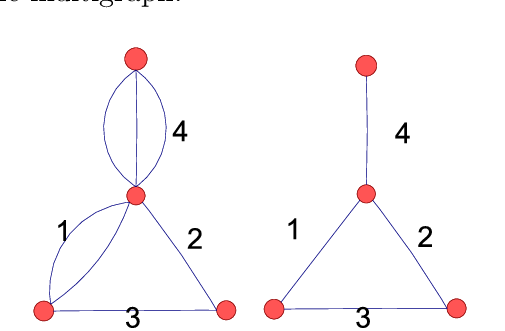

### Visualiising the nodes and their data using leaflet and matplotlib

C:\Users\natimerry\AppData\Local\Programs\Python\Python312\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


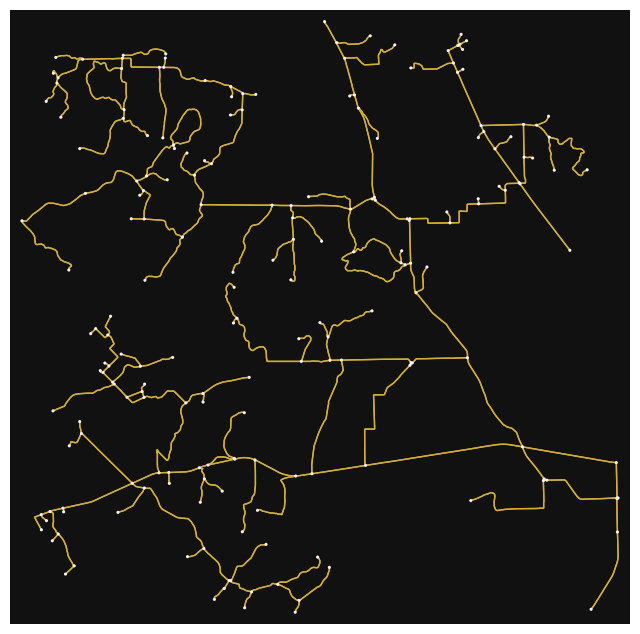

In [2]:
graph = ox.graph_from_address("texas", network_type = 'drive',dist=10000)
geodf_edge = ox.convert.graph_to_gdfs(
    graph, nodes=False, edges=True, node_geometry=False,
    fill_edge_geometry=True)

ox.plot_graph(graph,close=False,edge_color="#d4af37",node_size=5,node_color="#f9f1f1")

geodf_edge.explore()

## Visualising pathfinding over various (user-inputted) locations


### Setting up global variables
These variables define the initial variables used to set up a user interface for visualizing and interacting with street networks on a map. The main features include:

#### Map Setup
- **Base Map**: Utilizes OpenStreetMap tiles as the base map.
- **Graph Data**: Manages street network data (nodes and edges) representing city streets, with preloaded street data for specific cities (e.g., Kolkata).

#### Interactive Markers
- **Start Marker**: Blue circular marker used to set the starting location on the map.
- **End Marker**: Red circular marker used to set the destination location on the map.

#### Customization Controls
- **Color Pickers**: Allows users to customize the color of paths and nodes displayed on the map.
- **Node Visualization**: Checkbox control to enable/disable the visualization of nodes (with a performance warning due to potential slowness).

#### Statistics Display
- Widgets are included to display:
  - **Time**
  - **Count**
  - **Distance**
  - **Travel Time Taken**

#### Responsive Layout
- The interface integrates several controls (e.g., color pickers, checkboxes, labels) into the map using a flexible layout system. This ensures that the map is interactive and customizable for users.

In [3]:
graph = nodes = edges = center = m = from_marker = to_marker = box = dropdown = show_nodes = None
base = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
loading = True

preloaded = {"kolkata": "preloaded_graphs/kolkata.pickle"}


mapLayout=Layout(width='98%', height='690px')

from_marker_style = AwesomeIcon(
                        name='circle',
                        icon_color='white',
                        marker_color='blue',
                        spin=False
                        )

to_marker_style = AwesomeIcon(
                    name='circle',
                    icon_color='white',
                    marker_color='red',
                    spin=False
                    )

color_layout = widgets.Layout(width='240px')

path_color = widgets.ColorPicker(
                concise=False,
                description='Path Colour:',
                value='black',
                disabled=False,
                layout = color_layout
                )

path_control = WidgetControl(widget=path_color, position='bottomright')

node_color = widgets.ColorPicker(
                concise=False,
                description='Node Colour:',
                value='red',
                disabled=False,
                layout = color_layout
                )

node_control = WidgetControl(widget=node_color, position='bottomright')

show_nodes = widgets.Checkbox(value=False,description='Visualise Nodes (SLOW)')
show_node_control = WidgetControl(widget=show_nodes,position='bottomright',disabled=False)


time_label = widgets.Label(value="")
count_label = widgets.Label(value="")
distance_label = widgets.Label(value="")
travel_time_taken_label = widgets.Label(value="")




## Pathfinding Algorithms

This section implements the following algorithms:

- A\* 
- A\* traveltime
- Djikstra
- BFS traveltime

### Breadth-First Search (BFS) Algorithm

The **BFS algorithm** explores the graph by examining all nodes at the current depth level before moving to the next level. Here’s an overview of its operation:

**Initialization**: The algorithm begins by verifying the existence of the start and goal nodes in the graph. It then initializes a queue with the start node, a set to track visited nodes, and a `parent` dictionary to record each node's predecessor for path reconstruction.

**Exploration**: BFS removes nodes from the queue and explores their neighbors. Unvisited neighbors are added to the queue, and their parent is set to the current node.

**Pathfinding**: The search stops when the goal node is reached. The path is reconstructed by tracing back from the goal to the start node using the `parent` dictionary.

**Visualization**: If enabled, BFS marks each visited node on the map, clustering markers in groups of 100 for efficient rendering.

**Completion**: After the search, if the goal is found, the reconstructed path is returned. Otherwise, a list of all visited nodes is provided.

### Key Characteristics:
**Breadth-Wise Exploration**: BFS ensures that all nodes at the current depth are explored before proceeding to the next depth level.

**Guaranteed Shortest Path**: BFS guarantees finding the shortest path in an unweighted graph, but real maps often have weighted edges, affecting pathfinding.

**Time Complexity**: The time complexity is O(V + E), where V is the number of vertices and E is the number of edges.


In [4]:
def bfs(G, start, goal=None):
    if start not in G:
        raise ValueError(f"Start node {start} not in the graph.")
    if goal is not None and goal not in G:
        raise ValueError(f"Goal node {goal} not in the graph.")

    queue = deque([start])
    visited = set([start])
    parent = {start: None}
    g_costs = {start: 0}
    time_taken = {start: 0}
    circles = []

    while queue:
        current_node = queue.popleft()
        path = []  # Path is reconstructed once we find the goal node

        if show_nodes.value:
            circle = Circle(location=(G.nodes[current_node]["y"], G.nodes[current_node]["x"]),
                            radius=1,
                            color=node_color.value,
                            fill_color=node_color.value)
            circles.append(circle)
        
        if len(circles) > 100:
            marker_cluster = MarkerCluster(markers=circles)
            m.add_layer(marker_cluster)
            circles.clear()
            print("Marker added")

        # If we reached the goal, return the path
        if current_node == goal:
            # Reconstruct the path from goal to start
            while current_node is not None:
                path.append(current_node)
                current_node = parent[current_node]
            path.reverse()
            marker_cluster = MarkerCluster(markers=circles)
            m.add_layer(marker_cluster)
            print("Found solution: ", path)
            return path, g_costs, time_taken

        # Explore neighbors
        for neighbor in G.neighbors(current_node):
            if neighbor not in visited:
                visited.add(neighbor)
                parent[neighbor] = current_node
                queue.append(neighbor)
                # Set g_costs and time_taken for BFS, even though BFS doesn't calculate these.
                g_costs[neighbor] = g_costs[current_node] + 1
                time_taken[neighbor] = 0  # Time is not used in BFS

    if goal is not None:
        return None
    return list(visited), g_costs, time_taken

### Dijkstra's Algorithm for Shortest Pathfinding

**Dijkstra's Algorithm** is a well-known method for finding the shortest path between nodes in a graph where edges have weights, such as distance, time, or cost. It is particularly useful for scenarios like road networks, where different segments of the road may have varying lengths or travel times.

The algorithm operates by using a priority queue, typically implemented as a min-heap, to always expand the node with the lowest current cost. This ensures that the shortest path is found efficiently. Dijkstra's Algorithm starts by expanding the node with the smallest cost from the start node and explores its neighbors. If a shorter path to a neighboring node is found, the cost is updated, and the node’s parent is recorded for later path reconstruction.

One of the key features of Dijkstra's Algorithm is its ability to handle weighted edges. It computes the shortest path based on the sum of the edge weights, rather than just the number of edges, ensuring that the path with the minimum total cost is selected.

The algorithm guarantees an optimal solution in terms of the shortest path for weighted graphs. It is particularly effective in real-life applications like road networks, where edge weights represent varying distances or costs between nodes.

Visualization of the algorithm can show the explored nodes and the path, illustrating how Dijkstra's Algorithm determines the optimal route. Additionally, it can track and display statistics such as total path distance and travel time, depending on the edge weights used.

In terms of performance, Dijkstra's Algorithm has a time complexity of O((V + E) log V), where V is the number of vertices and E is the number of edges. The use of a priority queue ensures efficient exploration of the graph.


### A* Algorithm for Shortest Pathfinding

The **A* (A-star) Algorithm** improves upon Dijkstra's algorithm by incorporating a heuristic function that estimates the remaining distance to the goal, making it more efficient for many practical applications, such as navigation and AI pathfinding.

#### Key Features of the Algorithm:

The A (A-star) Algorithm* improves upon Dijkstra's algorithm by using a heuristic function to estimate the remaining travel time to the goal. This approach makes it more efficient for practical applications, such as navigation and AI pathfinding, where travel time is a critical factor.

A* uses the Haversine formula as its heuristic to estimate the cost from the current node to the goal. This choice is particularly suited for geographic distance calculations on a spherical surface.

The total cost in A* is calculated as f(n) = g(n) + h(n), where g(n) represents the actual travel time from the start to the current node, and h(n) is the heuristic estimate of the travel time from the current node to the goal. By combining these factors, A* explores fewer nodes compared to Dijkstra, resulting in faster performance in many cases.

A* guarantees finding the shortest path if the heuristic is admissible, meaning it never overestimates the true travel time to the goal. With an appropriate heuristic, A* will yield the same result as Dijkstra in optimal scenarios.

#### Comparison with Dijkstra:

Efficiency: A* is generally more efficient than Dijkstra because the heuristic function directs the search towards the goal, reducing unnecessary exploration of nodes, especially in large graphs or grids. In contrast, Dijkstra explores uniformly in all directions, which can lead to more exhaustive searches.

Computational Overhead: While A* incurs additional overhead from calculating the heuristic at each step, this is often outweighed by the significant reduction in the number of nodes explored.

#### Use Cases:
- Graphs were djikstra would take too long computationally, A* is a better choice

### Traveltime Variants

In addition to the standard versions of Dijkstra and A*, the project also includes variants that account for **travel time** instead of the physical length of roads. This allows the algorithms to find the fastest route, rather than the shortest one, making them more suitable for real-world street navigation where traffic conditions, road speed limits, and other factors impact travel time. These variants are particularly beneficial in applications like GPS navigation, where minimizing travel time is often more important than minimizing distance.


In [5]:

import numpy as np

def astar_fast(G,start,goal,travel_time=False,djikstra=False):
    print(travel_time)
    global show_nodes
    print("Starting A* algorithm, please wait")
    def heuristic(node,target):
        to = G.nodes[target]["y"],G.nodes[target]["x"]
        fr = G.nodes[node]["y"],G.nodes[node]["x"]
        if not djikstra:
            return haversine(to,fr,unit='m')
        else:
            return 0
    open_set = []
    heapq.heappush(open_set, (0, start, [start]))    
    g_costs = {start: 0}
    dists = {start:0}
    time_taken = {start:0}
    circles=[]
    while open_set:
        _, current_node, path = heapq.heappop(open_set)
        if show_nodes.value:
            circle = Circle(location = (graph.nodes[current_node]["y"], graph.nodes[current_node]["x"]),
                radius = 1,
                color = node_color.value,
                fill_color = node_color.value)
            circles.append(circle)
        if len(circles)>100:
            marker_cluster = MarkerCluster(markers=circles)
            m.add_layer(marker_cluster)
            circles.clear()
            print("marker added")
        # If we reached the goal, return the path
        if current_node == goal:
            marker_cluster = MarkerCluster(markers=circles)
            m.add_layer(marker_cluster)
            print("Fount solution: ",path)
            return path,(g_costs if not travel_time else dists),time_taken
        # Explore neighbors
        for neighbor in G.adj[current_node]:
            # Get all edges between current_node and neighbor
            for key, edge_attr in G[current_node][neighbor].items():
                lane_speedup = 0.5
                if 'lanes' in edge_attr:
                    print(edge_attr['lanes'])
                    if type(edge_attr['lanes'] == type([])):
                        lane_speedup = max([int(x) for x in edge_attr['lanes']])
                
                x = float(edge_attr['travel_time']/lane_speedup)
                if travel_time:
                    tentative_g_cost = g_costs[current_node] + x
                    if neighbor not in dists or tentative_g_cost < dists[neighbor]:
                        dists[neighbor]= dists[current_node] + (edge_attr['length'])
                else:
                    tentative_g_cost = g_costs[current_node] + (edge_attr['length'])

                if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                    g_costs[neighbor] = tentative_g_cost
                    f_cost = tentative_g_cost + (heuristic(neighbor,goal))
                    heapq.heappush(open_set, (f_cost, neighbor, path + [neighbor]))
                
                time_from_last = time_taken[current_node] + (edge_attr['travel_time']/lane_speedup)
                if neighbor not in time_taken or time_from_last < time_taken[neighbor]:
                    time_taken[neighbor] = (time_taken[current_node] + x)

    return None    
    

## Usage of GeoPandas for Adding Layers visualising the path

In the `draw_path` function, **GeoPandas** is employed to visualize the computed path on the map by performing the following steps:

1. **Path Construction**:
   - The function computes the path using different algorithms (e.g., A*, Dijkstra, BFS) and extracts the geometry of the path segments between nodes.

2. **Geometry Extraction**:
   - For each segment of the path, the function checks if geometry data is present in the graph's edge attributes.
   - If geometry data exists, it is directly used; otherwise, the function creates a `LineString` object using the coordinates of the nodes.

3. **GeoDataFrame Creation**:
   - A `GeoDataFrame` is created from the list of path segments, which includes line geometries representing the path on the map.

4. **Layer Addition**:
   - A `GeoData` layer is generated from the `GeoDataFrame` with a specified style (color and weight) to represent the path.
   - This layer is then added to the map using `m.add_layer()`, allowing visualization of the computed path with the desired styling.

5. **Memory Management**:
   - After adding the layer, the `path` variable is deleted to free up memory.


In [6]:
def draw_path(G,source,target,algo):
    start = timeit.default_timer()
    if source == target:
        alg = {'distances': {source: 0}, 'prev_vertices': {source: source}, 'count': 0}
    
    if algo=='astar':
        path = (astar_fast(G,source,target))
    elif algo == 'astar (traveltime)':
        path = (astar_fast(G,source,target,travel_time=True))
    elif algo == 'djikstra':
        path = (astar_fast(G,source,target,djikstra=True))
    elif algo == 'djikstra (traveltime)':
        path = (astar_fast(G,source,target,travel_time=True,djikstra=True))
    elif algo == 'bfs':
        path = (bfs(G,source,target))
    print(path)
    path,distance,time =path[0],path[1][target],path[2][target]

    end = (timeit.default_timer() - start) * 1000
    
    edges = []
    
    for i in range(len(path)-1):
        if 'geometry' in G[path[i]][path[i+1]][0]: # im sorry to my future self when he reads this
            edges.append(G[path[i]][path[i+1]][0]['geometry'])
        else:
            # next 2 lines are chatgpt magic...
            x = [path[i], path[i+1]]
            edges.append(LineString(nodes.loc[x].geometry.values)) 
    
    path = gpd.GeoDataFrame(edges,columns=['geometry'])
    path_layer = GeoData(geo_dataframe=path,style={'color': path_color.value, 'weight': 4})
    m.add_layer(path_layer)
    
    del path
    return end, 0,distance,time


The `assign_closest_node` function assigns the marker to the closest node on the actual map

In [7]:
def assign_closest_node(marker):
    nearest_node = ox.nearest_nodes(graph,marker.location[1],marker.location[0],return_dist=False)
    marker.nearest_node = nearest_node
    return

In [8]:
def fix_location(event):
    global dropdown
    marker = event['owner']
    assign_closest_node(marker)
    try:
        alg = dropdown.value
    except:
        alg = 'astar'
    marker.location = graph.nodes[marker.nearest_node]["y"], graph.nodes[marker.nearest_node]["x"]
    time_label.value = "changed location to nearest valid node"
    count_label.value = ""
    distance_label.value = ""
    travel_time_taken_label = ""

### `loadmap` Function Process

The `loadmap` function handles the dynamic loading and visualization of map data. It begins by displaying a loading progress bar to indicate data retrieval. The function then checks if a graph is already loaded and clears existing data if necessary. Depending on user input, it either loads a pre-saved graph or fetches new data from OpenStreetMap, enhancing it with edge speeds and travel times for accurate pathfinding.

Next, it converts the graph data into GeoDataFrames for nodes and edges, initializes a map centered on the first node, and sets up interactive elements including markers for the start and end points. The function adds a dropdown menu for selecting pathfinding algorithms and buttons for visualizing the path and clearing the map.

Pathfinding results are computed and displayed when the user clicks the visualize button, showing statistics like elapsed time, nodes traversed, distance, and travel time. The clear button allows users to reset the map view. If an error occurs, the function resets all components and informs the user of any issues.

Overall, the `loadmap` function provides an interactive map experience with flexible pathfinding options and visual feedback.


In [9]:
def loadmap(wdgt):
    
    global graph,nodes,edges,center,m,from_marker,to_marker,dropdown,show_nodes,show_node_control,travel_time_taken_label
    loading = widgets.IntProgress(value=10,min=0,max=10,description="Loading data",
                bar_style='', # 'success', 'info', 'warning', 'danger' or ''
                style={'bar_color': 'green'},
                orientation='horizontal'
                )
    box.children = [box.children[0], loading]
    
    value = wdgt['new']
    
    try:
        if graph is not None:
            del graph
            del nodes
            del edges
            del center
            del m
            del from_marker
            del to_marker
            # print(value.lower())
        if (value in preloaded):
            graph = pickle.load(open(preloaded[value], "rb"))            

        else:
            graph = ox.graph_from_address(value, network_type = 'drive',dist=10000)
        
        graph  = ox.add_edge_speeds(graph,hwy_speeds={
    'motorway':80,
    'living_street':40,
    'road':10,
    'primary':80,
    'secondary':15,
    'residential':10,
    'unclassified':10,
    'tertiary':10,
    'trunk':80
    },fallback=30
                            )
        graph = ox.add_edge_travel_times(graph)
                    
        nodes, edges = ox.graph_to_gdfs(graph)
        

        
        center = graph.nodes[nodes.index[0]]["y"], graph.nodes[nodes.index[0]]["x"]
        
        m = Map(center = center, 
                basemap = basemaps.OpenStreetMap.Mapnik,
                zoom = 18,
                max_zoom = 18,
                min_zoom = 8,
                scroll_wheel_zoom = True, 
                layout = mapLayout)
    
        print(type(m))
             
        from_marker = Marker(location=center, icon=from_marker_style)
        to_marker = Marker(location=center, icon=to_marker_style)

        
        from_marker.observe(lambda event: fix_location(event), 'location')
        to_marker.observe(lambda event: fix_location(event), 'location')
        
        assign_closest_node(from_marker)
        assign_closest_node(to_marker)
        m.add_layer(from_marker)
        m.add_layer(to_marker)
        
    
        
        dropdown = widgets.Dropdown(
                    options=['astar','astar (traveltime)', 'bfs','djikstra','djikstra (traveltime)'],
                    value="astar",
                    description='Algorithm:',
                    tooltip='Select algorithm to visualize',
                    disabled=False,
                    )
        
        dropdown_control = WidgetControl(widget=dropdown, position='topright')
        
        dropdown_control = WidgetControl(widget=dropdown, position='topright')

        layout = widgets.Layout(width='100px', height='30px')
        
        

        button = widgets.Button(
            description='Visualize',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click to visualize selected pathfinding algorithm',
            icon='play', # (FontAwesome names without the `fa-` prefix)
            layout = layout
        )
        
        minx,miny,maxx,maxy = nodes.total_bounds
        # print((miny,minx),(mayx,maxy))
        bounding_box = Rectangle(
                    bounds=((miny,minx),(maxy,maxx)),
                    color = 'green',
        )
    
        m.add_layer(bounding_box)
        def button_action(arg):
            x = draw_path(graph,from_marker.nearest_node,to_marker.nearest_node,dropdown.value)
            if x is not None:
                time_label.value = "elapsed time: " + str(x[0]) + ' ms'
                count_label.value = "nodes traversed: " + str(x[1])
                distance_label.value = "total path distance: " + str(x[2]/1000) + " km"
                travel_time_taken_label.value = f"{x[3]/60} minutes"
            else:
                time_label.value = "No path found"
                count_label.value = ""
                distance_label.value = ""
        
        button.on_click(button_action)
        button_control = WidgetControl(widget=button, position='topright')

        clear = widgets.Button(
            description='Clear Map',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Clear nodes and path from map',
            icon='trash', 
            layout = layout
        )
        
        def clear_action(arg):
            m.clear_layers()
            m.add_layer(from_marker)
            m.add_layer(to_marker)
            m.add_layer(base)
            m.add_layer(bounding_box)
            


        clear.on_click(clear_action)
        clear_control = WidgetControl(widget=clear, position='topright')
        
        m.add_control(dropdown_control)
        m.add_control(button_control)
        m.add_control(clear_control)
        m.add_control(path_control)
        m.add_control(node_control)
        m.add_control(show_node_control)
        
        box.children = [box.children[0], widgets.Label(value="Total Nodes: " + str(len(nodes))),
                        widgets.Label(value="Total Edges: " + str(len(edges))), 
                        m,time_label, count_label, distance_label,travel_time_taken_label]
        # ox.plot_graph(graph, show=False, close=False,edge_color="#d4af37",node_size=5,node_color="#f9f1f1")
        edges.explore()
    except EOFError:
        # print(e)
        graph = nodes = edges = center = m = from_marker = to_marker = dropdown = None
        box.children = [box.children[0], widgets.Label(value="Couldn't find location try again (e.g. Monaco)")]
    
regionInput = widgets.Text(
                value = 'Address:',
                placeholder = 'Type a Location',
                description = 'Location:',
                disabled = False,
                )   


regionInput.continuous_update=False

regionInput.observe(loadmap,'value')

box_layout = widgets.Layout(display='flex',
                flex_flow='column',
                width='100%',
                height='100%')

box = widgets.HBox([regionInput], layout=box_layout)


### Example output (for PDF files)
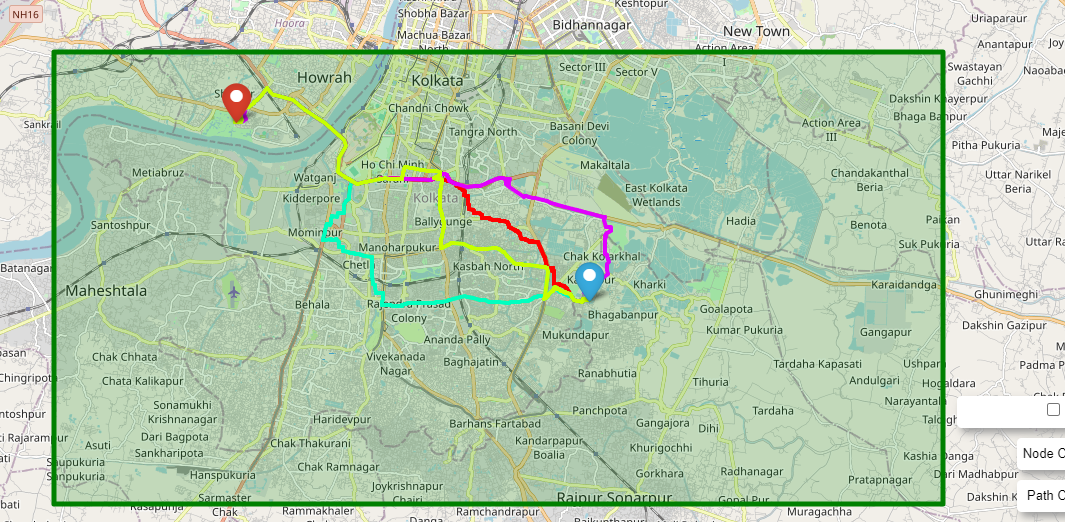

- Red (djikstra / A*)
- Lime green (djikstra traveltime)
- Cyan (A* traveltime)
- Pink (BFS)

In [10]:

display(box)


# The results:
Both Standard A* and Dijkstra's Algorithms equal performance. In the cities tested, both algorithms generally converge on the same paths; however, A* consistently outperforms Dijkstra in terms of computational speed, owing to its heuristic-driven approach.

When evaluating pathfinding with travel time as the cost metric, notable differences emerge between A* and Dijkstra. For shorter distances, the discrepancy in travel time between the two algorithms ranges from 10% to 30%. This variation arises because, although both algorithms aim to minimize travel time, their methods of achieving this can lead to divergent paths. For longer distances, the differences become less predictable and are significantly influenced by the specific layout of the city’s road network.

An analysis of the algorithms' behavior reveals that Dijkstra's Algorithm, when optimized for travel time, tends to favor larger roads with higher lane counts and generally avoids residential streets. This preference is due to its method of evaluating paths based on total travel time, which often favors major roads over smaller, potentially slower routes.

In contrast, A* Algorithm, despite its heuristic advantages, sometimes selects suboptimal routes when travel time is considered. It can be misguided by heuristics that favor initially perceived faster routes, which may lead into slower residential areas if the heuristic mistakenly prioritizes these over more efficient routes. This can occur if the heuristic eliminates what appears to be slower paths initially, only to find that these paths are actually faster in the overall context.

Future enhancements could involve integrating real-world speed limits and other detailed data to refine pathfinding accuracy. However, acquiring such comprehensive data is currently beyond the scope of this project.